In [41]:
install.packages("VancouvR")
install.packages("geojsonio")
install.packages("cancensus")
install.packages("sf")
install.packages("units")

Warning message:
"package 'VancouvR' is in use and will not be installed"
Warning message:
"package 'geojsonio' is in use and will not be installed"
Warning message:
"package 'cancensus' is in use and will not be installed"
Warning message:
"package 'sf' is in use and will not be installed"
Warning message:
"package 'units' is in use and will not be installed"


In [42]:
library(geojsonio)
library(tidyverse)
library(dplyr)
library("knitr")
library(units)

In [2]:

library(cancensus)
options(cancensus.api_key='CensusMapper_f228791d9506a7a747ece66db73b95be')
options(cancensus.cache_path = "/cache")

Census data is currently stored temporarily.

 In order to speed up performance, reduce API quota usage, and reduce unnecessary network calls, please set up a persistent cache directory via `set_cancensus_cache_path('<local cache path>', install = TRUE)`.
 This will add your cache directory as environment varianble to your .Renviron to be used across sessions and projects.





In [32]:
census_data <- get_census(dataset='CA16', regions=list(CSD="5915022"), vectors=c("v_CA16_401","v_CA16_404","v_CA16_406","v_CA16_1","v_CA16_2396","v_CA16_2510"), labels="detailed", geo_format="sf", level='DA')

Reading vectors data from local cache.



Reading geo data from local cache.



In [33]:
colnames(census_data)

[1] "Shape Area"                                                                                                                                    
 [2] "Type"                                                                                                                                          
 [3] "Households"                                                                                                                                    
 [4] "CD_UID"                                                                                                                                        
 [5] "Dwellings"                                                                                                                                     
 [6] "GeoUID"                                                                                                                                        
 [7] "Population"                                                                                                                                    
 [8] "CSD_UID"                                                                                                                                       
 [9] "CT_UID"                                                                                                                                        
[10] "CMA_UID"                                                                                                                                       
[11] "Region Name"                                                                                                                                   
[12] "Area (sq km)"                                                                                                                                  
[13] "v_CA16_401: Population, 2016"                                                                                                                  
[14] "v_CA16_404: Total private dwellings"                                                                                                           
[15] "v_CA16_406: Population density per square kilometre"                                                                                           
[16] "v_CA16_1: Age Stats"                                                                                                                           
[17] "v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data"                                           
[18] "v_CA16_2510: Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data"
[19] "geometry"

In [71]:
census_data_clean <- census_data|>
    rename(
        name = 'GeoUID',
        households = Households, 
        dwellings = Dwellings, 
        population = `v_CA16_401: Population, 2016` , 
        region = `Region Name` , 
        area_sq_km = `Area (sq km)`, 
        age =  `v_CA16_1: Age Stats` , 
        income = `v_CA16_2396: Total - Income statistics in 2015 for private households by household size - 100% data`     
    )|>
    select(name, households, dwellings, population, region, area_sq_km, age, income)|>
    filter(region == "Vancouver")|>
    glimpse()

Rows: 993
Columns: 9
$ name       <chr> "59150307", "59150308", "59150309", "59150310", "59150311",…
$ households <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174, 275, 246,…
$ dwellings  <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189, 307, 264,…
$ population <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, 782, 683…
$ region     <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vancouver, Vanc…
$ area_sq_km <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08706, 0.172…
$ age        <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510, 785, 680…
$ income     <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175, 275, 250,…
$ geometry   <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIPOLYGON (…


In [6]:

library("sf")

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE



In [75]:
census_data_st <- st_sf(census_data_clean, geometry = census_data_clean$geometry, crs = 4326)
census_data_centroid <- st_centroid(census_data_clean)

In [7]:
library(VancouvR)
search_cov_datasets("property-tax") %>%
  select(dataset_id,title)

dataset_id,title
<chr>,<chr>
property-tax-report-2006-2010,Property tax report 2006-2010
property-tax-report-2016-2019,Property tax report 2016-2019
property-tax-report-2011-2015,Property tax report 2011-2015
property-tax-report,Property tax report


In [8]:
tax_data <- get_cov_data(dataset_id = "property-tax-report-2016-2019",
                         where="tax_assessment_year='2016'",
                         select = "current_land_value, land_coordinate as tax_coord")|>
    as.tibble()
glimpse(tax_data) # read in the data of land value, and changed it coordname to tax coord, so it matched the property polygon data

Warning message:
"`as.tibble()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` instead.
ℹ The signature and semantics have changed, see `?as_tibble`."

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `current_land_value =
  .Primitive("as.integer")(current_land_value)`.
Caused by warning:
! NAs introduced by coercion to integer range"


Rows: 199,924
Columns: 2
$ current_land_value <int> 362000, 4217000, 346000, 287000, 1883000, 228000, 1…
$ tax_coord          <chr> "12060598", "58911893", "60318606", "64615992", "69…


In [9]:
colnames(tax_data)

[1] "current_land_value" "tax_coord"

In [150]:
url = "https://raw.githubusercontent.com/Irene-Berezin/econ326/refs/heads/main/crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv"
intentional_crime_data <- read_csv(url)|>
    rename(type = TYPE, year = YEAR, neighbourhood = NEIGHBOURHOOD, x = X, y = Y)|>
    select(type, year, neighbourhood, x, y)|>
    filter(!type %in% c("Vehicle Collision or Pedestrian Struck (with Fatality)",
    "Vehicle Collision or Pedestrian Struck (with Injury)",
    "Mischief"))|>
    filter(year == 2016)|>
    filter(x!=0, y!=0)|>
    group_by(type)|>
    arrange(year)

glimpse(intentional_crime_data)


Rows: 895823 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 34,582
Columns: 5
Groups: type [6]
$ type          <chr> "Other Theft", "Other Theft", "Other Theft", "Other Thef…
$ year          <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20…
$ neighbourhood <chr> "West End", "West End", "West End", "West End", "West En…
$ x             <dbl> 491004.8, 491004.8, 491007.8, 491007.8, 491007.8, 491007…
$ y             <dbl> 5459177, 5459177, 5459174, 5459174, 5459174, 5459174, 54…


In [151]:
intentional_crime_sf <- intentional_crime_data|>
    st_as_sf(coords = c("x", "y"), crs = 32610)|>
    st_transform(crs = 4326)|>
    glimpse()

Rows: 34,582
Columns: 4
Groups: type [6]
$ type          <chr> "Other Theft", "Other Theft", "Other Theft", "Other Thef…
$ year          <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20…
$ neighbourhood <chr> "West End", "West End", "West End", "West End", "West En…
$ geometry      <POINT [°]> POINT (-123.1237 49.28528), POINT (-123.1237 49.28…


In [153]:
intentional_crime_count <- intentional_crime_data|>
    mutate(neighbourhood = if_else(neighbourhood == "Central Business District", "Downtown", neighbourhood))|>
    group_by(type)|>
    summarize(crime_count = n())|>
    glimpse()

colnames(intentional_crime_count)[colnames(intentional_crime_count) == "neighbourhood"] <- "name"

Rows: 6
Columns: 2
$ type        <chr> "Break and Enter Commercial", "Break and Enter Residential…
$ crime_count <int> 2683, 2989, 11981, 12814, 2637, 1478


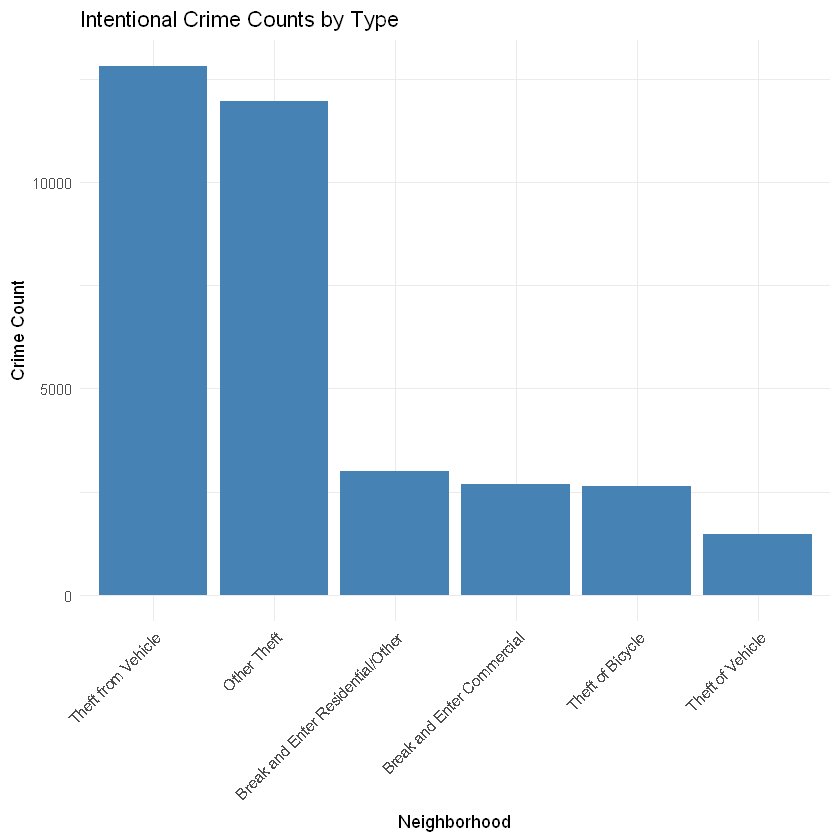

In [155]:
ggplot(intentional_crime_count, aes(x = reorder(type, -crime_count), y = crime_count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Intentional Crime Counts by Type",
       x = "Neighborhood",
       y = "Crime Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [147]:
local_area_boundary <- get_cov_data(dataset_id ="local-area-boundary")|>
    glimpse()

Reading data from temporary cache



Rows: 22
Columns: 4
$ name         <chr> "Arbutus Ridge", "Grandview-Woodland", "Kensington-Cedar …
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.27643960930…
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.07…


In [14]:
local_area_boundary_centroid <- local_area_boundary|>
    mutate(geometry = st_centroid(geometry))|>
    select(geometry)


st_sf(local_area_boundary_centroid, geometry = local_area_boundary_centroid$geometry, crs = 4326)


,geometry
,<POINT [°]>
1,POINT (-123.1617 49.2468)
2,POINT (-123.0667 49.27644)
3,POINT (-123.0729 49.24669)
4,POINT (-123.0376 49.21702)
5,POINT (-123.1633 49.26754)
6,POINT (-123.0882 49.27822)
7,POINT (-123.092 49.21876)
8,POINT (-123.2035 49.2684)
9,POINT (-123.1895 49.23796)


In [15]:
local_area_boundary_sf <- st_sf(local_area_boundary, geometry = local_area_boundary$geometry, crs = 4326)|>
    glimpse()

Rows: 22
Columns: 4
$ name         <chr> "Arbutus Ridge", "Grandview-Woodland", "Kensington-Cedar …
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.27643960930…
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.07…


In [16]:
property_polygons <- get_cov_data(dataset_id="property-parcel-polygons")

In [17]:
glimpse(property_polygons)

Rows: 99,939
Columns: 7
$ civic_number <chr> "4050", "4034", "4026", "4033", "4041", "4055", "5912", "…
$ streetname   <chr> "W 40TH AV", "W 40TH AV", "W 40TH AV", "W 41ST AV", "W 41…
$ tax_coord    <chr> "74703048", "74703062", "74703070", "75003063", "75003057…
$ site_id      <chr> "011037491", "009828028", "011037521", "011037971", "0110…
$ geom         <chr> "{\"coordinates\": [[[-123.1952054199714, 49.235263660093…
$ geo_point_2d <chr> "49.23541759077318, -123.19531316487794", "49.23541632098…
$ geometry     <POLYGON [°]> POLYGON ((-123.1952 49.2352..., POLYGON ((-123.19…


In [21]:
land_price <- merge(tax_data, property_polygons, by = "tax_coord")|>
    glimpse() 


# Merge two datasets so we have land price and their geometry information in one single dataframe

Rows: 204,278
Columns: 8
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01…
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1…
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16…
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"…
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",…
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466…
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431…
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-…


In [22]:

land_price_sf <- st_sf(land_price, geometry = land_price$geometry, crs = 4326)


In [23]:
glimpse(land_price_sf)

Rows: 204,278
Columns: 8
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01…
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1…
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16…
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"…
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",…
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466…
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431…
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-…


In [85]:

install.packages("ggmap")
library(ggmap)


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'ggmap' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpUdojfI\downloaded_packages


ℹ Google's Terms of Service: <https://mapsplatform.google.com>
  Stadia Maps' Terms of Service: <https://stadiamaps.com/terms-of-service/>
  OpenStreetMap's Tile Usage Policy: <https://operations.osmfoundation.org/policies/tiles/>
ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.


In [86]:
key = '953a00a4-1c69-45b1-a0e4-b3492abdf92b'

In [87]:
register_stadiamaps(key, write = FALSE)

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.

ℹ 42 tiles needed, this may take a while (try a smaller zoom?)



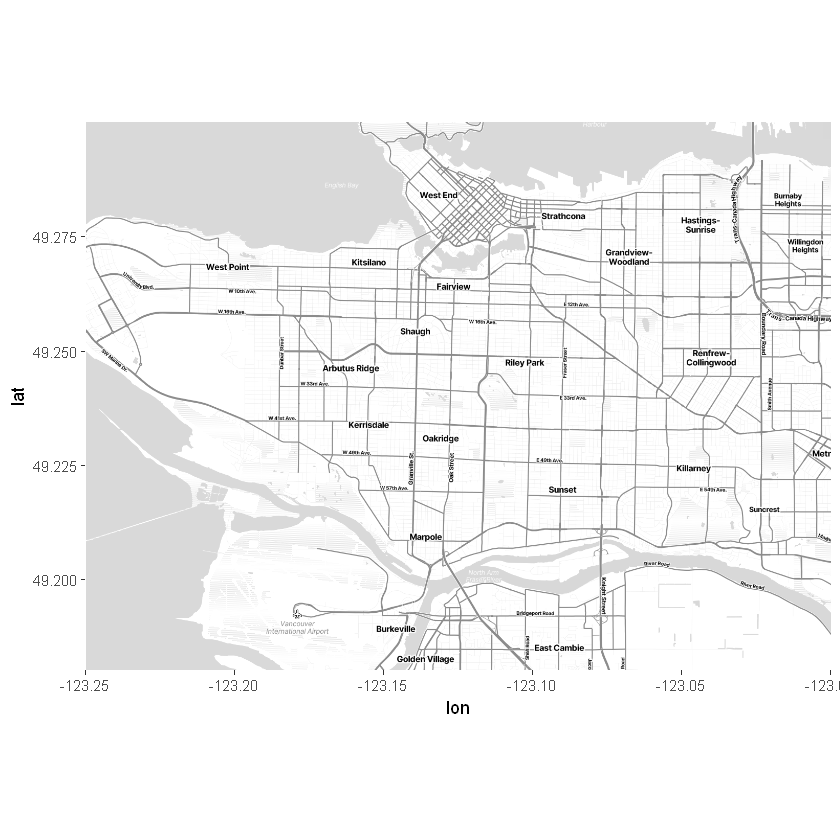

In [88]:
bbox <- c(left = -123.25, bottom = 49.18, right = -123.0, top = 49.3)

map <- get_stadiamap(bbox = bbox, zoom = 13, maptype = "stamen_toner_lite", filetype = "svg")
ggmap(map)

In [89]:
land_price_adjusted <- land_price_sf|>
mutate(current_land_value = current_land_value/1000000)

ERROR: Error in eval(expr, envir, enclos): object 'land_price_sf' not found


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)


ggmap(map) +
  geom_sf(data = land_price_adjusted, aes(fill = current_land_value, alpha = 0.6), inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Land Value") +
  theme_minimal() +
  labs(title = "Property Land Values", subtitle = "Colored by Current Land Value")

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


In [45]:
school_data <- get_cov_data(dataset_id = "schools")|>
    as.tibble()
glimpse(school_data)

Rows: 194
Columns: 7
$ address         <chr> "1110 Cotton Drive", "7835 Champlain Crescent", "7835 …
$ school_category <chr> "Public School", "Public School", "StrongStart BC", "P…
$ school_name     <chr> "Britannia Community Elementary", "Champlain Heights A…
$ geom            <chr> "{\"coordinates\": [-123.07137879542154, 49.2745120085…
$ geo_local_area  <chr> "Grandview-Woodland", "Killarney", "Killarney", "Kensi…
$ geo_point_2d    <chr> "49.27451200859733, -123.07137879542154", "49.21407843…
$ geometry        <POINT [°]> POINT (-123.0714 49.27451), POINT (-123.0305 49.…


In [60]:
school_data_st <- st_sf(school_data, geometry = school_data$geometry, crs = 4326)

In [49]:
ggmap(map) +
  geom_sf(data = land_price_adjusted, aes(fill = current_land_value),  alpha = 0.6, inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Land Value") +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Property Land Values", subtitle = "Colored by Current Land Value")

ERROR: Error in ggmap(map): could not find function "ggmap"


In [50]:
land_price_centroid <- land_price|>
mutate(geometry = st_centroid(geometry))|>
select(geometry)


st_sf(land_price_centroid, geometry = land_price_centroid$geometry, crs = 4326)




ERROR: Error in eval(expr, envir, enclos): object 'land_price' not found


In [51]:
glimpse(land_price_centroid)


ERROR: Error in eval(expr, envir, enclos): object 'land_price_centroid' not found


In [52]:
ggmap(map) +
  geom_sf(data = land_price_adjusted, aes(fill = current_land_value),  alpha = 0.6, inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Land Value") +
  geom_sf(data = land_price_centroid$geometry, color = "#ff0000", size = 0.5, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Property Land Values", subtitle = "Colored by Current Land Value")

ERROR: Error in ggmap(map): could not find function "ggmap"


In [53]:
closeness_metric <- function(c, s, alpha) {
"
Given two datasets of point geometries, creates a new dataframe 
of the weighted closeness index of each element of list one relative to all elements of list 2.
"
  closeness_values <- numeric(length(c))
  for (i in seq_along(c)) {
    distances <- as.numeric(st_distance(s, c[i]))
    decayed_influences <- exp(-alpha * distances)
    closeness_values[i] <- sum(decayed_influences)
  }
  return(data.frame(land_price_id = seq_along(c), closeness = closeness_values))
}


In [54]:
closeness_values <- closeness_metric(land_price_centroid$geometry, school_data$geometry, 0.001)

ERROR: Error in eval(expr, envir, enclos): object 'land_price_centroid' not found


In [ ]:
closeness_values <- pull(as.tibble(closeness_values))

land_price_sf$closeness_value <- closeness_values 


In [ ]:
glimpse(land_price_sf)

max(land_price_sf$closeness_value)
test <- land_price_sf|>
filter(closeness_value > 299)

test

Rows: 204,278
Columns: 9
$ tax_coord          <chr> "01963206", "01963229", "01963245", "01963265", "01…
$ current_land_value <int> 11366000, 10623000, 10763000, 10763000, 12864000, 1…
$ civic_number       <chr> "4888", "4898", "4874", "4850", "4811", "4818", "16…
$ streetname         <chr> "BELMONT AV", "FANNIN AV", "FANNIN AV", "FANNIN AV"…
$ site_id            <chr> "010862706", "010863915", "010863923", "010863931",…
$ geom               <chr> "{\"coordinates\": [[[-123.22221178283283, 49.27466…
$ geo_point_2d       <chr> "49.27488185499064, -123.22286857659084", "49.27431…
$ geometry           <POLYGON [°]> POLYGON ((-123.2222 49.2746..., POLYGON ((-…
$ closeness_value    <dbl> 1.387210, 1.310526, 1.374908, 1.432028, 1.619398, 1…


[1] 14.11312

tax_coord,current_land_value,civic_number,streetname,site_id,geom,geo_point_2d,geometry,closeness_value
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<GEOMETRY [°]>,<dbl>


In [ ]:
test

tax_coord,current_land_value,civic_number,streetname,site_id,geom,geo_point_2d,geometry,closeness_value
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<GEOMETRY [°]>,<dbl>


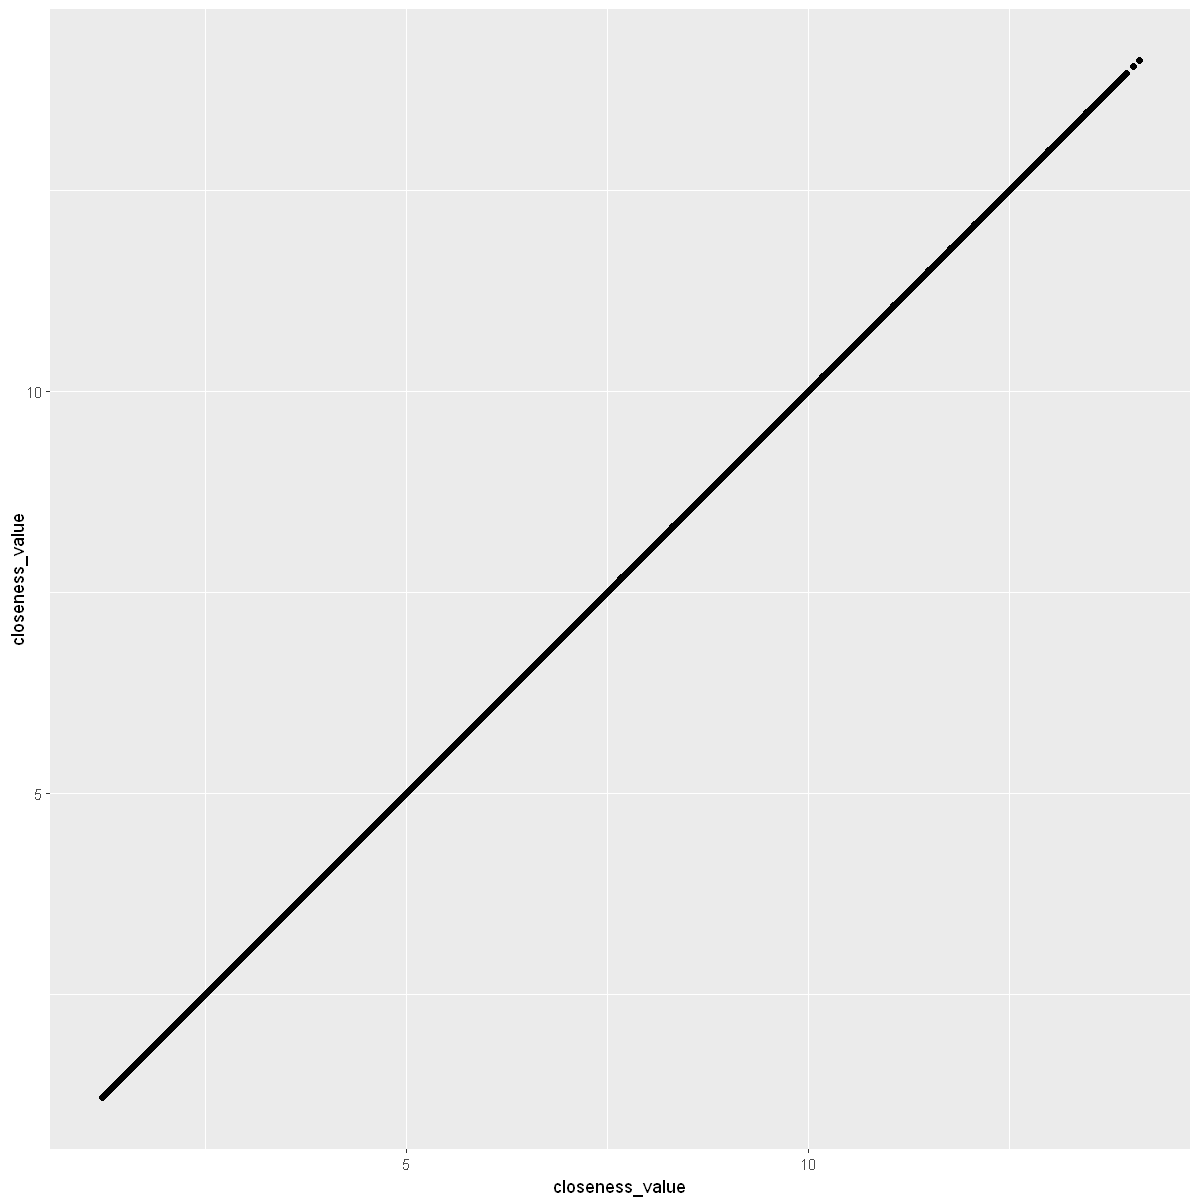

In [ ]:
plot <- land_price_sf|>
ggplot(aes(x=closeness_value, y=closeness_value))+geom_point()

plot

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


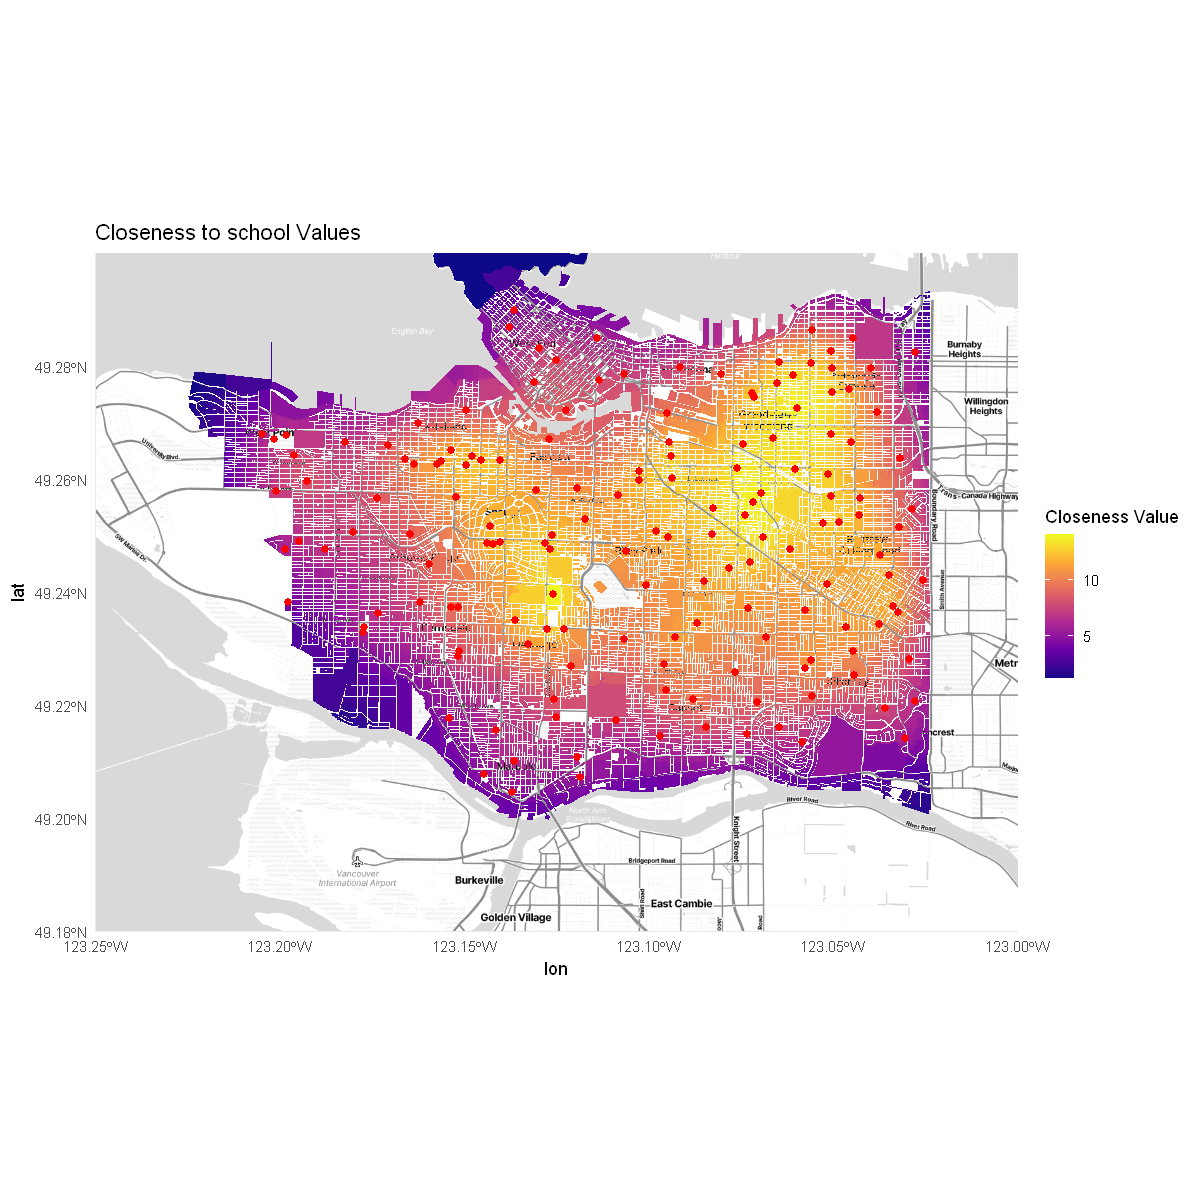

In [ ]:
ggmap(map) +
  geom_sf(data = land_price_sf, aes(fill = closeness_values), inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Closeness Value") +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Closeness to school Values")

In [98]:
light_data <- get_cov_data(dataset_id = 'street-lighting-poles')|>
    as.tibble()
glimpse(light_data)

Rows: 57,708
Columns: 6
$ block_number   <chr> "59", "23", "63", "13", "40", "86", "55", "12", "49", "…
$ node_number    <dbl> 1, 4, 2, 3, 4, 4, 3, 1, 7, 1, 4, 1, 2, 3, 1, 2, 2, 9, 3…
$ geom           <chr> "{\"coordinates\": [-123.08688645683188, 49.23384357188…
$ geo_local_area <chr> "Kensington-Cedar Cottage", "Arbutus Ridge", "Kensingto…
$ geo_point_2d   <chr> "49.23384357188207, -123.08688645683188", "49.255368339…
$ geometry       <POINT [°]> POINT (-123.0869 49.23384), POINT (-123.1596 49.2…


In [ ]:
closeness_values <- closeness_metric(local_area_boundary_centroid$geometry, light_data$geometry, 0.001)|>
    glimpse()

Rows: 22
Columns: 2
$ land_price_id <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ closeness     <dbl> 2443.471, 2857.987, 3418.503, 1769.030, 2470.933, 3148.4…


In [ ]:
local_school_closeness_values <- closeness_metric(local_area_boundary_centroid$geometry, school_data$geometry, 0.001)|>
    glimpse()

Rows: 22
Columns: 2
$ land_price_id <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ closeness     <dbl> 8.987104, 12.927986, 12.847694, 6.950690, 9.165381, 8.54…


In [ ]:
local_school_closeness_values <- pull(as.tibble(local_school_closeness_values))
local_area_boundary_sf$closeness_values <- local_school_closeness_values

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


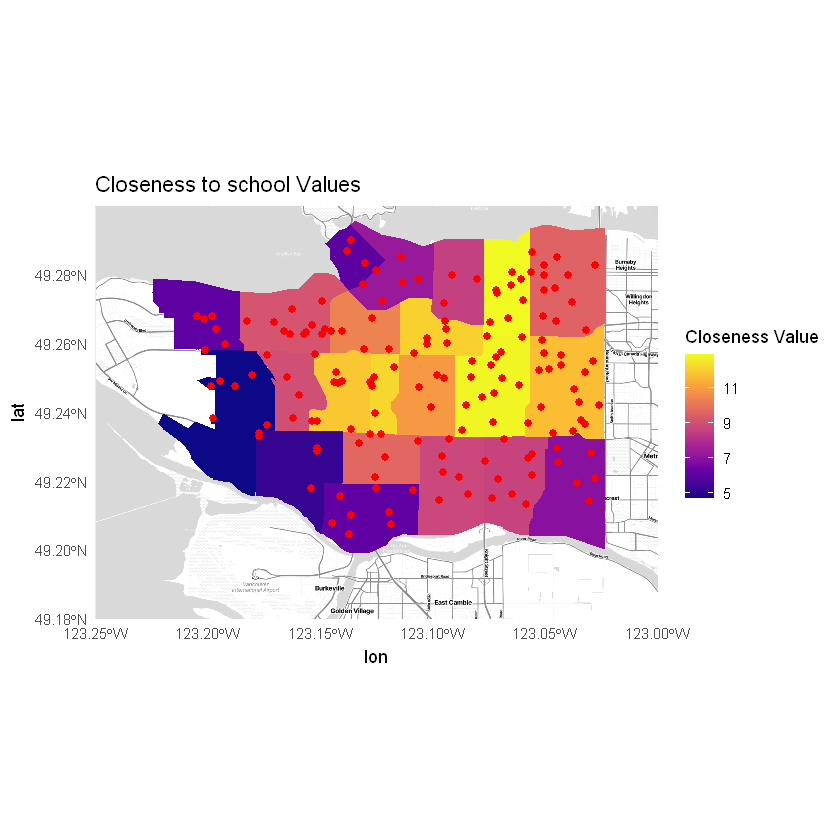

In [ ]:
ggmap(map) +
  geom_sf(data = local_area_boundary_sf, aes(fill = closeness_values), inherit.aes = FALSE, color = NA) +
  scale_fill_viridis_c(option = "plasma", name = "Closeness Value") +
  geom_sf(data = school_data$geometry, color = "#ff0000", size = 2, inherit.aes = FALSE) +
  theme_minimal() +
  labs(title = "Closeness to school Values")

In [ ]:

local_area_boundary_sf <- merge(local_area_boundary_sf, intentional_crime_count, by = "name")|>
    glimpse()

Rows: 22
Columns: 5
$ name         <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairvi…
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.28074707013…
$ crime_count  <int> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.11…


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


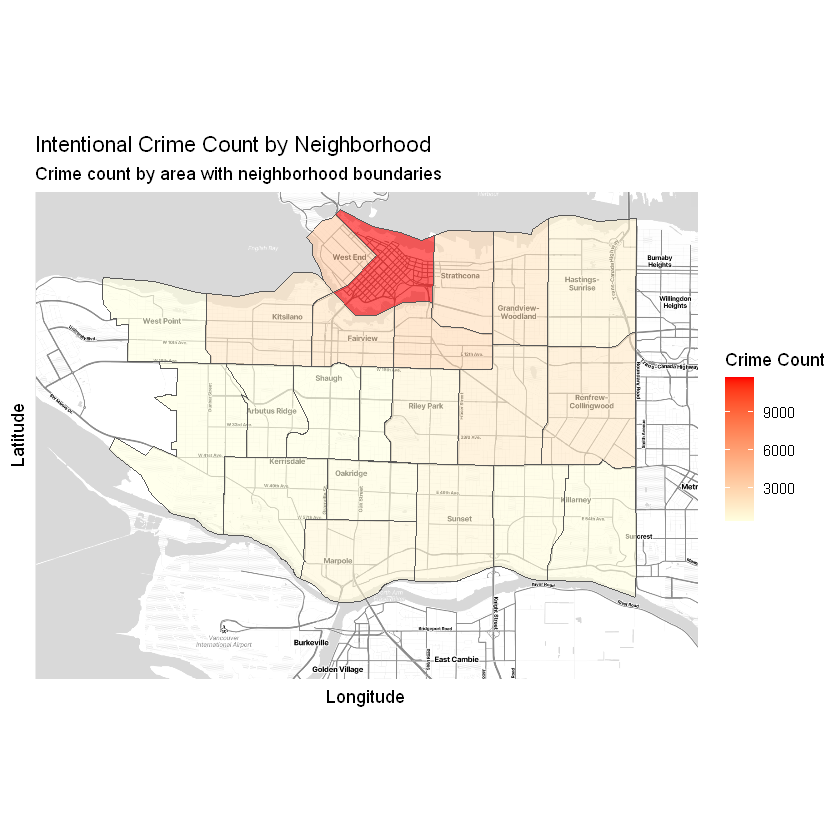

In [ ]:
ggmap(map) +
  geom_sf(data = local_area_boundary_sf, aes(fill = crime_count), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "lightyellow", high = "red", name = "Crime Count") +
  labs(title = "Intentional Crime Count by Neighborhood",
       subtitle = "Crime count by area with neighborhood boundaries",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())

In [ ]:
population_data <- data.frame(
  name = c(
    "Arbutus Ridge",
    "Downtown",
    "Dunbar-Southlands",
    "Fairview",
    "Grandview-Woodland",
    "Hastings-Sunrise",
    "Kensington-Cedar Cottage",
    "Kerrisdale",
    "Killarney",
    "Kitsilano",
    "Marpole",
    "Mount Pleasant",
    "Oakridge",
    "Renfrew-Collingwood",
    "Riley Park",
    "Shaughnessy",
    "South Cambie",
    "Strathcona",
    "Sunset",
    "Victoria-Fraserview",
    "West End",
    "West Point Grey"
  ),
  population = c(
    15295,
    62030,
    21425,
    33620,
    29175,
    34575,
    49325,
    13975,
    29325,
    43045,
    24460,
    32955,
    13030,
    51530,
    22555,
    8430,
    7970,
    12585,
    36500,
    31065,
    47200,
    13065
  )
)|>
glimpse()

Rows: 22
Columns: 2
$ name       <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairview…
$ population <dbl> 15295, 62030, 21425, 33620, 29175, 34575, 49325, 13975, 293…


In [ ]:
local_area_boundary_sf <- merge(local_area_boundary_sf, population_data, by = "name")|>
    glimpse()



Rows: 22
Columns: 6
$ name         <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairvi…
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.28074707013…
$ crime_count  <int> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ population   <dbl> 15295, 62030, 21425, 33620, 29175, 34575, 49325, 13975, 2…
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.11…


In [ ]:
census_crime_rate <- local_area_boundary_sf |>
    mutate(
        count = as.numeric(`crime_count`),           # Use backticks if necessary
        population = as.numeric(`population`), # Use backticks if necessary
        crime_rate = (crime_count / population) * 100000
    ) |>
    glimpse()

Rows: 22
Columns: 8
$ name         <chr> "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairvi…
$ geom         <chr> "{\"coordinates\": [[[-123.15259552001952, 49.25722503568…
$ geo_point_2d <chr> "49.24680490982789, -123.16166923820482", "49.28074707013…
$ crime_count  <int> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ population   <dbl> 15295, 62030, 21425, 33620, 29175, 34575, 49325, 13975, 2…
$ geometry     <POLYGON [°]> POLYGON ((-123.1526 49.2572..., POLYGON ((-123.11…
$ count        <dbl> 414, 11705, 391, 2140, 2021, 1111, 1580, 461, 505, 1793, …
$ crime_rate   <dbl> 2706.767, 18869.902, 1824.971, 6365.259, 6927.164, 3213.3…


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


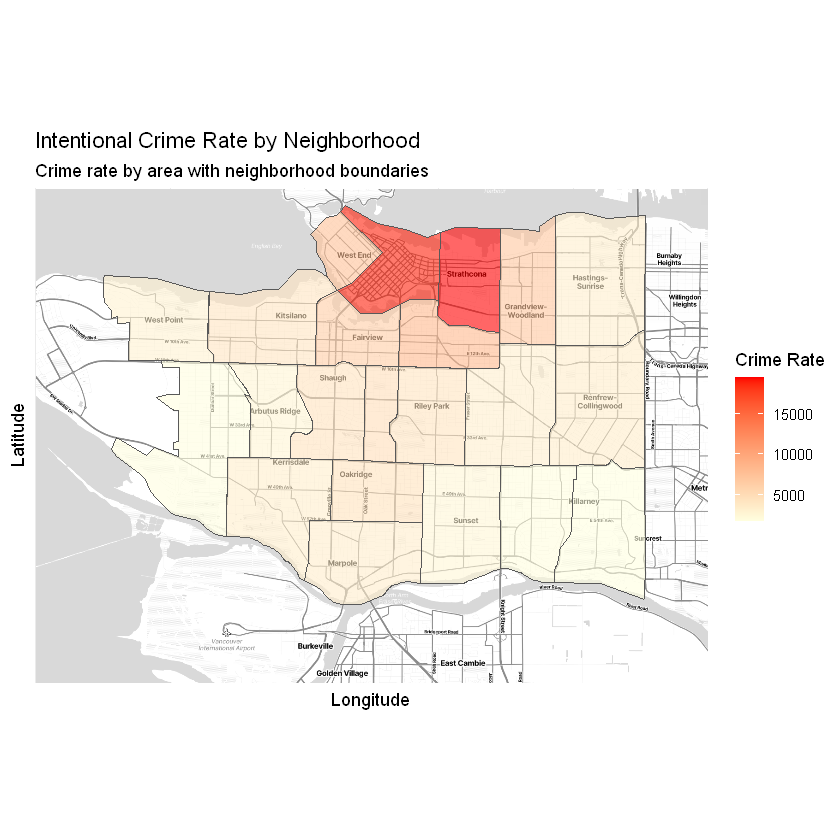

In [ ]:
ggmap(map) +
  geom_sf(data = census_crime_rate, aes(fill = crime_rate), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "lightyellow", high = "red", name = "Crime Rate") +
  labs(title = "Intentional Crime Rate by Neighborhood",
       subtitle = "Crime rate by area with neighborhood boundaries",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())

In [ ]:
average_crime_rate <- mean(census_crime_rate$crime_rate)

average_crime_rate

[1] 5435.953

In [104]:
compute_accessibility_index <- function(local_areas, points_of_interest) {
  local_areas <- st_transform(local_areas, crs = 4326)
  points_of_interest <- st_transform(points_of_interest, crs = 4326)
  
  # local_areas <- left_join(local_areas, population_data, by = "name")
  
  areas_union <- st_union(local_areas)
  points_of_interest <- st_intersection(points_of_interest, areas_union)
  
  area_centroids <- st_centroid(local_areas)
  
  # Calculate average distance from each local area to points of interest
  distance_matrix <- st_distance(area_centroids, points_of_interest)
  distance_matrix_km <- set_units(distance_matrix, "km")
  avg_distance_km <- apply(distance_matrix_km, 1, mean, na.rm = TRUE)
  local_areas$avg_distance_km <- avg_distance_km
  
  # Calculate points of interest density
  local_areas$area_km2 <- st_area(local_areas) %>% set_units("km^2") %>% set_units(NULL)

  points_in_areas <- st_join(points_of_interest, local_areas, join = st_within)
  poi_counts <- points_in_areas %>%
    st_set_geometry(NULL) %>%
    group_by_at("name") %>%
    summarise(poi_count = n())
  
  local_areas <- left_join(local_areas, poi_counts, by = "name")
  local_areas$poi_count[is.na(local_areas$poi_count)] <- 0

  local_areas$poi_density <- local_areas$poi_count / local_areas$area_km2
  
  # Calculate points per 10,000 population
  local_areas$poi_per_10k_pop <- (local_areas$poi_count / local_areas$population) * 10000
  
  # Normalize the values ([0, 1] range)
  normalize <- function(x) {
    return((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))
  }
  
  local_areas$avg_distance_norm <- normalize(avg_distance_km)
  local_areas$poi_density_norm <- normalize(local_areas$poi_density)
  local_areas$poi_per_10k_pop_norm <- normalize(local_areas$poi_per_10k_pop)
  
  local_areas$avg_distance_norm_inv <- 1 - local_areas$avg_distance_norm
  
  local_areas$accessibility_index <- 10*(local_areas$avg_distance_norm_inv +
                                      local_areas$poi_density_norm +
                                      local_areas$poi_per_10k_pop_norm) / 3
  
  
  return(local_areas)
}


In [105]:
census_population <- census_data_clean|>
    select(name, population)|>
    glimpse()
    

Rows: 993
Columns: 3
$ name       <chr> "59150307", "59150308", "59150309", "59150310", "59150311",…
$ population <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, 782, 683…
$ geometry   <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIPOLYGON (…


In [111]:
school_census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = school_data_st
)|>
  glimpse()

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 19
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", …
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174…
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189…
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50…
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc…
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0…
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51…
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175…
$ avg_distance_km       <dbl> 7.535841, 7.253416, 6.976612, 7.089322, 6.790936…
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, …
$ poi_count             <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, …
$ geometry              <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MUL…
$ poi_density     

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


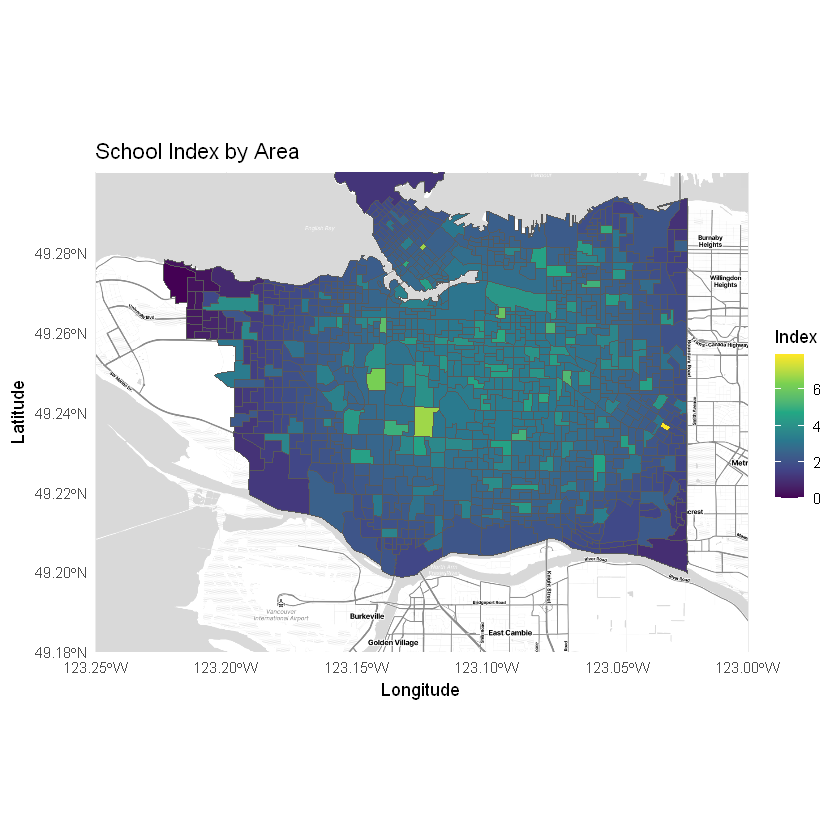

In [112]:
ggmap(map) +
  geom_sf(data = school_census_with_index, aes(fill = accessibility_index),inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "School Index by Area", fill = "Index", x = "Longitude", y = "Latitude")

In [113]:
light_data_st <- st_sf(light_data, geometry = light_data$geometry, crs = 4326)

In [ ]:
light_census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = light_data_st
)|>
  glimpse()

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 19
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", …
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174…
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189…
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50…
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc…
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0…
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51…
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175…
$ avg_distance_km       <dbl> 7.535841, 7.253416, 6.976612, 7.089322, 6.790936…
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, …
$ poi_count             <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, …
$ geometry              <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MUL…
$ poi_density     

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


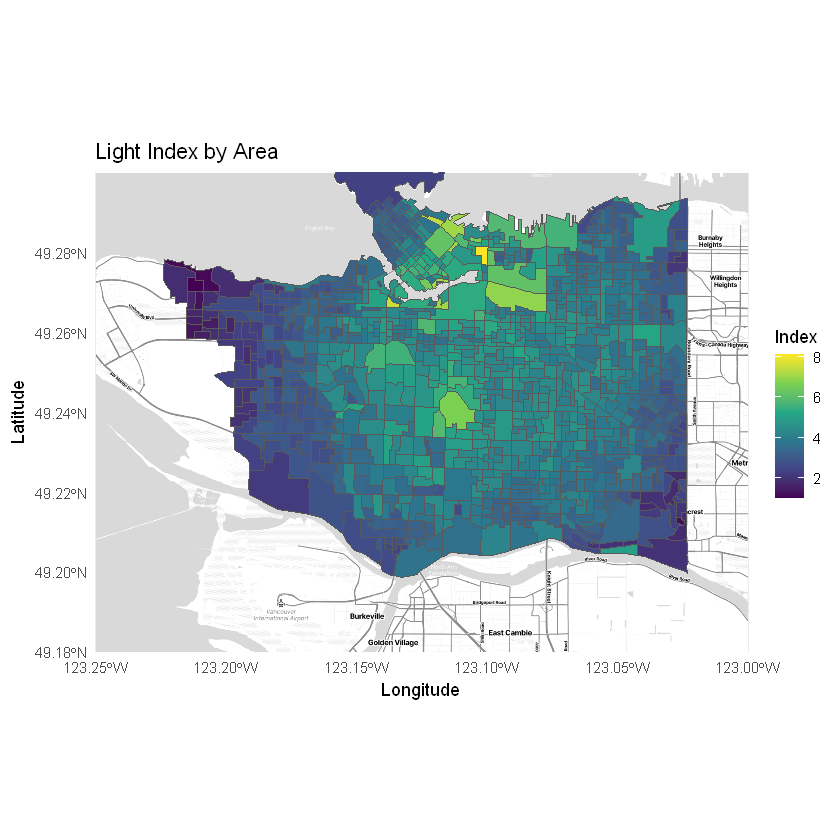

In [110]:
ggmap(map) +
  geom_sf(data = light_census_with_index, aes(fill = accessibility_index),inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Light Index by Area", fill = "Index", x = "Longitude", y = "Latitude")

In [114]:
bus_stops <- st_read("./transit_data/Stops.shp")

local_areas <- st_read("./transit_data/local-area-boundary.geojson")

bus_census_with_index <- compute_accessibility_index(
  local_areas = census_data_st,
  points_of_interest = bus_stops
)|>
  glimpse()

Reading layer `Stops' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\transit_data\Stops.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 8785 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -123.4231 ymin: 49.00439 xmax: -122.3029 ymax: 49.47356
Geodetic CRS:  WGS 84
Reading layer `local-area-boundary' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\transit_data\local-area-boundary.geojson' 
  using driver `GeoJSON'
Simple feature collection with 22 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -123.2248 ymin: 49.19894 xmax: -123.0232 ymax: 49.29581
Geodetic CRS:  WGS 84


Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 19
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", …
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174…
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189…
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50…
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc…
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0…
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51…
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175…
$ avg_distance_km       <dbl> 7.549866, 7.286136, 7.014300, 7.132412, 6.844344…
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, …
$ poi_count             <dbl> 2, 1, 2, 9, 1, 2, 3, 2, 6, 1, 1, 1, 2, 1, 1, 0, …
$ geometry              <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MUL…
$ poi_density     

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


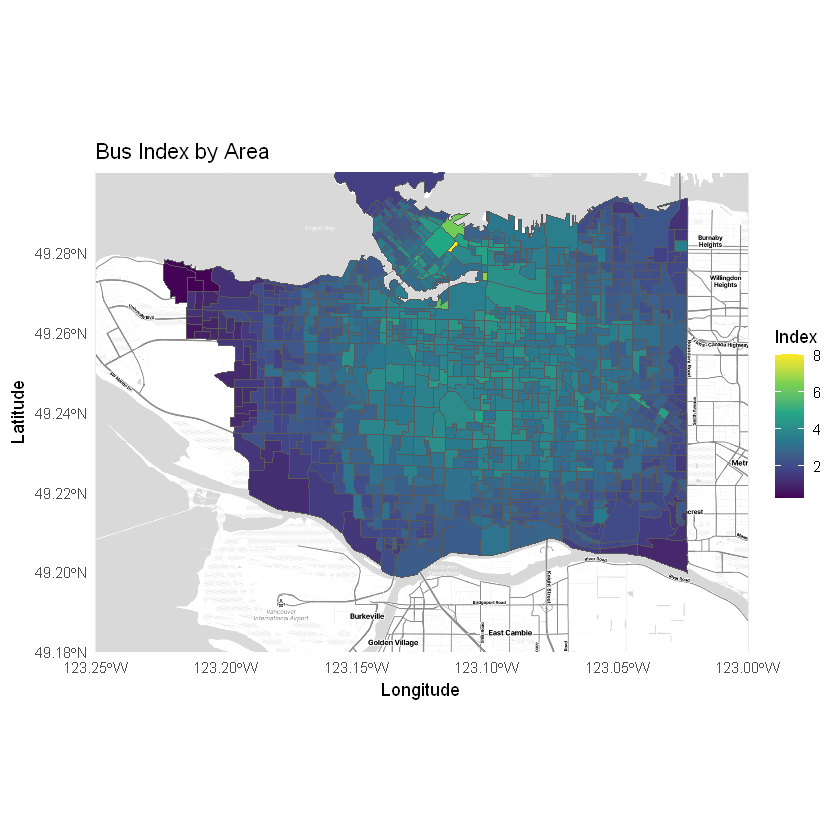

In [115]:
ggmap(map) +
  geom_sf(data = bus_census_with_index, aes(fill = accessibility_index),inherit.aes = FALSE) +
  scale_fill_viridis_c() +
  coord_sf(crs = st_crs(4326)) +
  theme_minimal() +
  labs(title = "Bus Index by Area", fill = "Index", x = "Longitude", y = "Latitude")

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Rows: 993
Columns: 19
$ name                  <chr> "59150307", "59150308", "59150309", "59150310", …
$ households            <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174…
$ dwellings             <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189…
$ population            <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 50…
$ region                <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vanc…
$ area_sq_km            <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.0…
$ age                   <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 51…
$ income                <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175…
$ avg_distance_km       <dbl> 6.937434, 6.781250, 6.501630, 6.696112, 6.440844…
$ area_km2              <dbl> 0.29829107, 0.10920474, 0.11154401, 0.10904415, …
$ poi_count             <dbl> 28, 16, 31, 24, 14, 13, 20, 15, 23, 12, 15, 12, …
$ geometry              <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MUL…
$ poi_density     

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


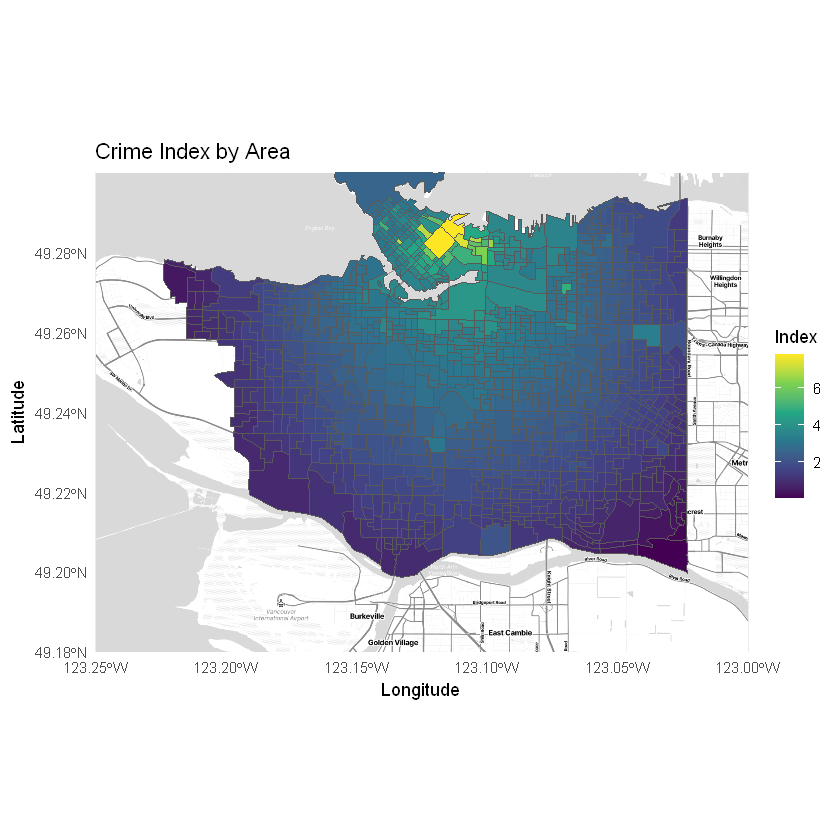

In [143]:
crime_in_census_divisions <- st_join(intentional_crime_sf, census_data_st, left = FALSE)

crime_counts <- crime_in_census_divisions %>%
  group_by(name) %>% 
  summarise(crime_count = n())|>
  st_drop_geometry()|>
  glimpse()

Rows: 993
Columns: 2
$ name        <chr> "59150307", "59150308", "59150309", "59150310", "59150311"…
$ crime_count <int> 28, 16, 31, 24, 14, 13, 20, 15, 23, 12, 15, 12, 8, 8, 8, 1…


In [145]:
census_data_with_crime <- census_data_st %>%
  left_join(crime_counts, by = "name") %>%
  mutate(crime_count = ifelse(is.na(crime_count), 0, crime_count))

census_data_with_crime <- census_data_with_crime %>%
  mutate(crime_rate = crime_count / population * 10000)|>
  glimpse()

Rows: 993
Columns: 11
$ name        <chr> "59150307", "59150308", "59150309", "59150310", "59150311"…
$ households  <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174, 275, 246…
$ dwellings   <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189, 307, 264…
$ population  <dbl> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506, 782, 68…
$ region      <fct> Vancouver, Vancouver, Vancouver, Vancouver, Vancouver, Van…
$ area_sq_km  <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08706, 0.17…
$ age         <dbl> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510, 785, 68…
$ income      <dbl> 255, 205, 270, 280, 180, 205, 405, 170, 335, 175, 275, 250…
$ crime_count <int> 28, 16, 31, 24, 14, 13, 20, 15, 23, 12, 15, 12, 8, 8, 8, 1…
$ geometry    <MULTIPOLYGON [°]> MULTIPOLYGON (((-123.0233 4..., MULTIPOLYGON …
$ crime_rate  <dbl> 443.0380, 319.3613, 416.1074, 447.7612, 263.1579, 231.3167…


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


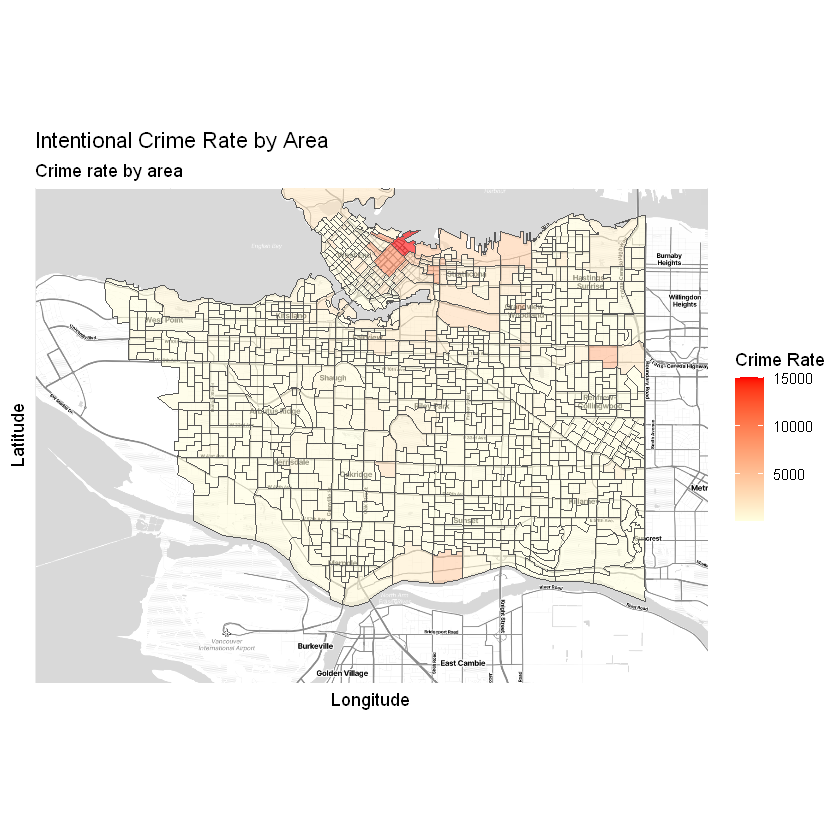

In [146]:
ggmap(map) +
  geom_sf(data = census_data_with_crime, aes(fill = crime_rate), inherit.aes = FALSE, alpha = 0.6) +
  scale_fill_gradient(low = "lightyellow", high = "red", name = "Crime Rate") +
  labs(title = "Intentional Crime Rate by Area",
       subtitle = "Crime rate by area",
       x = "Longitude", y = "Latitude") +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank())